<a href="https://colab.research.google.com/github/harry-vaibhav-agarwal/Machine-Learning/blob/main/Diagnosis2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Copy and Unzip Data and Labels

In [72]:
# Python library for copying files from My Drive
import shutil
import warnings
warnings.filterwarnings("ignore")

In [79]:

# Ignore if running locally
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [107]:
# Ignore if running locally
# Otherwise change `drive/My Drive/Colab Notebooks/Data/ISIC2018_Task3_Training_*.zip` to /path/to/data
shutil.copy2("/content/drive/MyDrive/Data/Training_GroundTruth.zip", "./")
shutil.copy2("/content/drive/MyDrive/Data/Training_Input.zip", "./")

'./Training_Input.zip'

In [89]:
!unzip -q Training_GroundTruth.zip

replace ISIC2018_Task3_Training_GroundTruth/ATTRIBUTION.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [108]:
!unzip -q Training_Input.zip

## Attribution

In [90]:
print(open("ISIC2018_Task3_Training_GroundTruth/ATTRIBUTION.txt").read())

ISIC-2018 Challenge: Task 3: Training Ground Truth (HAM10000 Dataset: https://arxiv.org/abs/1803.10417 ) (c) by ViDIR Group, Department of Dermatology, Medical University of Vienna

ISIC-2018 Challenge: Task 3: Training Ground Truth (HAM10000 Dataset: https://arxiv.org/abs/1803.10417 ) is licensed under a
Creative Commons Attribution-NonCommercial 4.0 International License.

You should have received a copy of the license along with this
work. If not, see <http://creativecommons.org/licenses/by-nc/4.0/>.



## Make labels/data FAST.AI ready

In [6]:
import os
import math
import pandas as pd
import numpy as np

In [7]:
np.random.seed(42)

In [8]:
df = pd.read_csv("ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv")

In [9]:
for col in df.columns:
  if col != "image":
    s = df[col].sum()
    c = df[col].count()
    print("Column: {}\t Count: {}\t Percentage: {}".format(col, s, round((s/c)*100, 2)))

Column: MEL	 Count: 1113.0	 Percentage: 11.11
Column: NV	 Count: 6705.0	 Percentage: 66.95
Column: BCC	 Count: 514.0	 Percentage: 5.13
Column: AKIEC	 Count: 327.0	 Percentage: 3.27
Column: BKL	 Count: 1099.0	 Percentage: 10.97
Column: DF	 Count: 115.0	 Percentage: 1.15
Column: VASC	 Count: 142.0	 Percentage: 1.42


In [10]:
# Image classes are in individual columns
# Created a new column name `class` 
# which contains values from 0-6
df["class"] = df.drop("image", axis=1).apply(lambda x: x.to_numpy().argmax(), axis=1)

In [11]:
# What each value means in the `class` column
a = list(df.columns)
for i in ["image", "class"]:
  a.remove(i)
a = dict(zip(a, range(len(a))))
print(a)

{'MEL': 0, 'NV': 1, 'BCC': 2, 'AKIEC': 3, 'BKL': 4, 'DF': 5, 'VASC': 6}


In [12]:
df.drop(a.keys(), axis=1, inplace=True)

In [13]:
df.to_csv("isic_labels.csv", index=False)

### Extract Validation Dataset

In [14]:
test_idx = []
for c in df["class"].unique():
    # get all the image names from a particular class
    temp = df[df['class'].apply(lambda x: True if x == c else False)]
    # extract 10% of images from each class
    test_idx += temp.sample(math.floor(temp.shape[0]/10)).index.to_list()

In [15]:
# create a test dataframe
test_df = df.iloc[test_idx].reset_index(drop=True)

In [16]:
# create a train dataframe
train_df = df.drop(labels=test_idx).reset_index(drop=True)

In [17]:
train_df.to_csv("isic_train_labels.csv", index=False)
test_df.to_csv("isic_test_labels.csv", index=False)

### Oversampling

In [18]:
df = pd.read_csv("isic_train_labels.csv")

In [104]:
# class NV has highest number of images
sum(df["class"] == 1)

6035

In [20]:
classes = df["class"].unique()
max_val = 6035

In [19]:
path = "Training_Input"
def cloning(img, count):
  """
  img: Image Name
  count: Number of times `img` needs to be copied.
  """
  images = []
  for i in range(count):
    ii = img+"_"+str(i)
    img_path = os.path.join(path, img+".jpg")
    ii_path = os.path.join(path, ii+".jpg")
    # Creating a copy of `img` in the file system
    shutil.copy(img_path, ii_path)
    images.append(ii)
  return images

In [23]:

images, labels = [], []
for c in classes:
    if c == 1:
        continue
    data = df[df["class"].apply(lambda x: True if x == c else False)]
    l = data.image.shape[0]
    rest = max_val - (math.floor(max_val/l)*l)
    ns = [j+1 if i < rest else j for i, j in enumerate([math.floor(max_val/l)]*l)]
    for i, n in zip(data.image.values, ns):
        images += cloning(i, n)
        labels += [c]*n

In [24]:
# `oversampled` do not contain any class `1` image
oversampled = pd.DataFrame({"image": images, "class": labels})

In [25]:
df_1 = df[df["class"].apply(lambda x: True if x == 1 else False)]

In [26]:
balanced = pd.concat([oversampled, df_1]).reset_index(drop=True) # New balanced dataset

In [27]:
# For data_block api to understand which image is for training
# and which one is for validation
balanced["is_valid"] = False
test_df["is_valid"] = True

In [28]:
balanced = pd.concat([balanced, test_df]).reset_index(drop=True)

In [ ]:
# balanced[-10:]

In [29]:
balanced.to_csv("isic_labels_balanced.csv", index=False)

## Start Coding FAST

In [118]:
!curl https://course.fast.ai/setup/colab | bash

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  9127    0  9127    0     0  43461      0 --:--:-- --:--:-- --:--:-- 43879
bash: line 1: syntax error near unexpected token `newline'
bash: line 1: `<!DOCTYPE html>'


In [31]:
from fastai.vision import *

In [66]:
# Copied from lesson3-planet.ipynb
tfms = get_transforms(max_rotate=20, max_zoom=1.5, max_lighting=0.5, max_warp=0.4, p_affine=1., p_lighting=1., flip_vert=True)

tfms.

([RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True), RandTransform(tfm=TfmAffine (dihedral_affine), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True), RandTransform(tfm=TfmCoord (symmetric_warp), kwargs={'magnitude': (-0.4, 0.4)}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True), RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-20, 20)}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True), RandTransform(tfm=TfmAffine (zoom), kwargs={'scale': (1.0, 1.5), 'row_pct': (0, 1), 'col_pct': (0, 1)}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True), RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.25, 0.75)}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True), RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.5, 2.0)}, p=1.0, resolved={}, do_run=True, 

In [33]:
src = (ImageList.from_csv("./", "isic_labels_balanced.csv", folder="Training_Input", suffix=".jpg")
                .split_from_df() # uses `is_valid` column
                .label_from_df())

In [76]:
print(src)

LabelLists;

Train: LabelList (42245 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
0,0,0,0,0
Path: .;

Valid: LabelList (998 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
1,1,1,1,1
Path: .;

Test: None


After this, I did a bunch of training using various Resnet models and training sizes.

---


```
Recall(average="macro") == Balanced Accuracy
```

### Resnet 34 with size 224

In [47]:
transformed_data = src.transform(tfms, size=224)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3503: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3503: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale

In [74]:

db = transformed_data.databunch(bs=16, num_workers=4)

print(db)


ImageDataBunch;

Train: LabelList (42245 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
0,0,0,0,0
Path: .;

Valid: LabelList (998 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
1,1,1,1,1
Path: .;

Test: None


data.train_dl.batch_size

In [73]:
db.show_batch

<bound method DataBunch.show_batch of ImageDataBunch;

Train: LabelList (42245 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
0,0,0,0,0
Path: .;

Valid: LabelList (998 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
1,1,1,1,1
Path: .;

Test: None>

In [75]:

learn = cnn_learner(db, models.resnet34, metrics=error_rate)
learn.lr_find()




#print(learn)

#learn = cnn_learner(dataset1, models.resnet34, metrics=Recall(average="macro"))
#learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


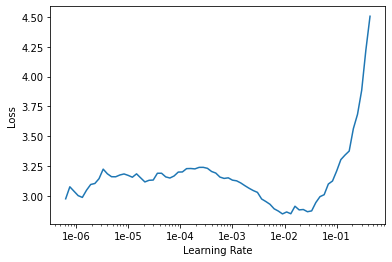

In [78]:
learn.recorder.plot()

In [80]:
learn.fit(epochs=3, lr= 3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,0.849461,0.833860,0.357715,17:25
1,0.797085,0.659204,0.290581,17:47
2,0.639436,0.596898,0.232465,17:48


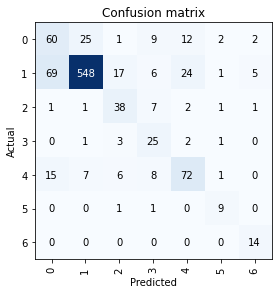

In [81]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

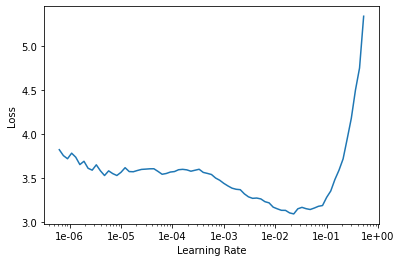

In [70]:
learn.recorder.plot()

In [83]:
# After training every stage I copy it to my drive.
learn.save('stage1-sz224-rn34')
shutil.copy2("./models/stage1-sz224-rn34.pth", "./drive/My Drive/Colab Notebooks/Data/models/models")

'./drive/My Drive/Colab Notebooks/Data/models/models'

In [ ]:
learn.save('stage2-sz224-rn34')
shutil.copy2("./models/stage2-sz224-rn34.pth", "./drive/My Drive/Colab Notebooks/Data/models/")

'./drive/My Drive/Colab Notebooks/Data/models/stage2-sz224-rn34.pth'

### Resnet 34

#### Size 64

In [91]:
transformed_data = src.transform(tfms, size=64)
           

In [92]:
db = transformed_data.databunch(bs=16,num_workers=5)

In [94]:
print(db)

ImageDataBunch;

Train: LabelList (42245 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
0,0,0,0,0
Path: .;

Valid: LabelList (998 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
1,1,1,1,1
Path: .;

Test: None


In [ ]:
data.classes, data.c

([0, 1, 2, 3, 4, 5, 6], 7)

In [95]:
db.show_batch

<bound method DataBunch.show_batch of ImageDataBunch;

Train: LabelList (42245 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
0,0,0,0,0
Path: .;

Valid: LabelList (998 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
1,1,1,1,1
Path: .;

Test: None>

In [96]:
learn = cnn_learner(db, models.resnet34, metrics=[Recall(average="macro"),error_rate])

In [97]:
learn.lr_find()

epoch,train_loss,valid_loss,recall,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


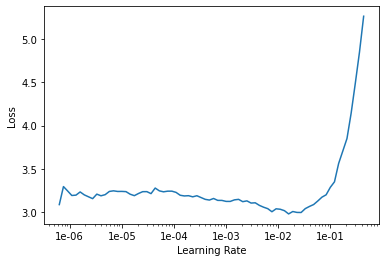

In [98]:
learn.recorder.plot()

In [99]:
learn.fit(epochs=3,lr=3e-3)

epoch,train_loss,valid_loss,recall,error_rate,time
0,1.207494,1.055213,0.612166,0.429860,09:49
1,1.024040,0.899484,0.661335,0.375751,09:56
2,0.966313,0.965804,0.657123,0.403808,09:51


In [100]:
learn.save('stage1-sz64-rn34')
shutil.copy2("./models/stage1-sz64-rn34.pth", "./drive/My Drive/Colab Notebooks/Data/models/models")

'./drive/My Drive/Colab Notebooks/Data/models/models'

In [101]:
learn.unfreeze()

In [102]:
learn.fit_one_cycle(5, slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,recall,error_rate,time
0,0.963600,0.823003,0.699348,0.341683,09:57
1,0.926202,0.808595,0.682555,0.356713,09:55
2,0.853513,0.703064,0.712368,0.289579,09:53
3,0.794052,0.762825,0.711880,0.307615,09:56
4,0.794869,0.755539,0.711191,0.300601,10:03


In [104]:
learn.save('stage2-sz64-rn34')
shutil.copy2("./models/stage2-sz64-rn34.pth", "./drive/My Drive/Colab Notebooks/Data/models/models")

'./drive/My Drive/Colab Notebooks/Data/models/models'

### Resnet 101

In [105]:
data = (src.transform(tfms, size=224)
        .databunch(bs=16,num_workers=6).normalize(imagenet_stats))

In [106]:
learn = cnn_learner(data, models.resnet101, metrics=[Recall(average="macro"),error_rate])

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth


In [107]:
learn.unfreeze()
learn.lr_find()


epoch,train_loss,valid_loss,recall,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


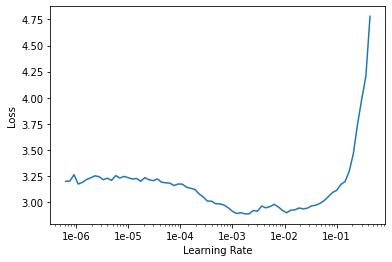

In [108]:
learn.recorder.plot()

In [109]:
learn.fit_one_cycle(5,slice(1e-4,1e-3))

epoch,train_loss,valid_loss,recall,error_rate,time
0,0.963758,0.982127,0.675147,0.365731,19:33
1,0.649910,0.698014,0.754548,0.309619,19:32
2,0.523116,0.439925,0.782865,0.168337,19:59
3,0.351479,0.422253,0.809630,0.170341,19:49
4,0.305457,0.380266,0.858692,0.148297,19:43


In [111]:
learn.save('stage1-sz224-rn101')
shutil.copy2("./models/stage1-sz224-rn101.pth", "./drive/My Drive/Colab Notebooks/Data/models/models")

'./drive/My Drive/Colab Notebooks/Data/models/models'

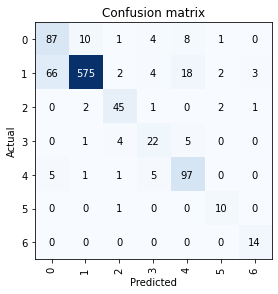

In [112]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

### Resnet 152

In [ ]:
data = (src.transform(tfms, size=224)
        .databunch(bs=16,num_workers=5).normalize(imagenet_stats))

In [ ]:
learn = cnn_learner(data, models.resnet152, metrics=[error_rate,accuracy,Recall(average="macro")])
learn.fit_one_cycle(4)

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.torch/models/resnet152-b121ed2d.pth
241530880it [00:10, 22546052.11it/s]


epoch,train_loss,valid_loss,recall,time
0,0.785708,0.709159,0.739327,21:32
1,0.519026,0.645384,0.815162,21:44
2,0.409894,0.487464,0.832022,21:45
3,0.328334,0.452459,0.847651,22:01
4,0.307490,0.468136,0.849233,21:59


In [ ]:
learn.save('stage1-sz224-rn152')
shutil.copy2("./models/stage1-sz224-rn152.pth", "./drive/My Drive/Colab Notebooks/Data/models/models")

'./drive/My Drive/Colab Notebooks/Data/models/stage1-sz224-rn152.pth'

In [ ]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()


epoch,train_loss,valid_loss,recall,time
0,0.286909,0.395956,0.855177,23:51
1,0.256752,0.413372,0.854086,23:14
2,0.214330,0.350319,0.857564,22:53
3,0.187390,0.351069,0.856926,22:40
4,0.169617,0.335280,0.848321,23:13


In [ ]:
learn.fit_one_cycle(2, slice(1e-6, 1e-4))

In [ ]:
learn.save('stage2-sz224-rn152')
shutil.copy2("./models/stage2-sz224-rn152.pth", "./drive/My Drive/Colab Notebooks/Data/models/models")

'./drive/My Drive/Colab Notebooks/Data/models/stage2-sz224-rn152.pth'

###  Focal Loss

In [113]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [114]:
# https://github.com/Hsuxu/Loss_ToolBox-PyTorch/blob/master/FocalLoss/FocalLoss.py
class FocalLoss(nn.Module):
    """
    This is a implementation of Focal Loss with smooth label cross entropy supported which is proposed in
    'Focal Loss for Dense Object Detection. (https://arxiv.org/abs/1708.02002)'
        Focal_Loss= -1*alpha*(1-pt)*log(pt)
    :param num_class:
    :param alpha: (tensor) 3D or 4D the scalar factor for this criterion
    :param gamma: (float,double) gamma > 0 reduces the relative loss for well-classified examples (p>0.5) putting more
                    focus on hard misclassified example
    :param smooth: (float,double) smooth value when cross entropy
    :param balance_index: (int) balance class index, should be specific when alpha is float
    :param size_average: (bool, optional) By default, the losses are averaged over each loss element in the batch.
    """

    def __init__(self, num_class, alpha=None, gamma=2, balance_index=-1, smooth=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.num_class = num_class
        self.alpha = alpha
        self.gamma = gamma
        self.smooth = smooth
        self.size_average = size_average

        if self.alpha is None:
            self.alpha = torch.ones(self.num_class, 1)
        elif isinstance(self.alpha, (list, np.ndarray)):
            assert len(self.alpha) == self.num_class
            self.alpha = torch.FloatTensor(alpha).view(self.num_class, 1)
            self.alpha = self.alpha / self.alpha.sum()
        elif isinstance(self.alpha, float):
            alpha = torch.ones(self.num_class, 1)
            alpha = alpha * (1 - self.alpha)
            alpha[balance_index] = self.alpha
            self.alpha = alpha
        else:
            raise TypeError('Not support alpha type')

        if self.smooth is not None:
            if self.smooth < 0 or self.smooth > 1.0:
                raise ValueError('smooth value should be in [0,1]')

    def forward(self, input, target):
        logit = F.softmax(input, dim=1)

        if logit.dim() > 2:
            # N,C,d1,d2 -> N,C,m (m=d1*d2*...)
            logit = logit.view(logit.size(0), logit.size(1), -1)
            logit = logit.permute(0, 2, 1).contiguous()
            logit = logit.view(-1, logit.size(-1))
        target = target.view(-1, 1)

        # N = input.size(0)
        # alpha = torch.ones(N, self.num_class)
        # alpha = alpha * (1 - self.alpha)
        # alpha = alpha.scatter_(1, target.long(), self.alpha)
        epsilon = 1e-10
        alpha = self.alpha
        if alpha.device != input.device:
            alpha = alpha.to(input.device)

        idx = target.cpu().long()

        one_hot_key = torch.FloatTensor(target.size(0), self.num_class).zero_()
        one_hot_key = one_hot_key.scatter_(1, idx, 1)
        if one_hot_key.device != logit.device:
            one_hot_key = one_hot_key.to(logit.device)

        if self.smooth:
            one_hot_key = torch.clamp(
                one_hot_key, self.smooth, 1.0 - self.smooth)
        pt = (one_hot_key * logit).sum(1) + epsilon
        logpt = pt.log()

        gamma = self.gamma

        alpha = alpha[idx]
        loss = -1 * alpha * torch.pow((1 - pt), gamma) * logpt

        if self.size_average:
            loss = loss.mean()
        else:
            loss = loss.sum()
        return loss

### Resnet 101 with Focal Loss

In [115]:
FL = FocalLoss(num_class=7, alpha=0.25, gamma=2.0, balance_index=2)

In [116]:
data = (src.transform(tfms, size=224)
        .databunch(bs=16,num_workers=5).normalize(imagenet_stats))

In [2]:
learn = cnn_learner(data, models.resnet101, metrics=[accuracy,error_rate,Recall(average="macro")], loss_func=FL)
learn.fit_one_cycle(4)

NameError: ignored

In [118]:
learn.save('stage1-sz224-rn101-fLoss')
shutil.copy2("./models/stage1-sz224-rn101-fLoss.pth", "./drive/My Drive/Colab Notebooks/Data/models/models")

'./drive/My Drive/Colab Notebooks/Data/models/models'

epoch,train_loss,valid_loss,accuracy,error_rate,recall,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


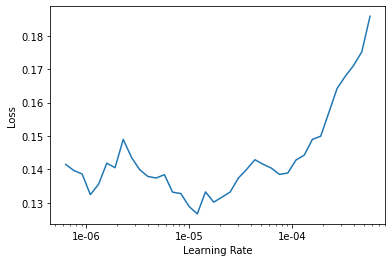

In [119]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()


In [1]:
learn.fit_one_cycle(2, slice(1e-6, 1e-5))

NameError: ignored

In [ ]:
learn.save('stage2-sz224-rn101-fLoss')
shutil.copy2("./models/stage2-sz224-rn101-fLoss.pth", "./drive/My Drive/Colab Notebooks/Data/models/models")

'./drive/My Drive/Colab Notebooks/Data/models/stage2-sz224-rn101-fLoss.pth'

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
interp.